In [2]:
import numpy as np
import matplotlib.pyplot as plt
import madmom
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)


In [3]:
def model_energy_peak(energy, rel_tol=0.05, fps=100):
    max = np.max(energy)
    min = np.min(energy)
    tol = rel_tol*(max-min)
    amax = np.argmax(energy)
    left_min = np.min(energy[:amax])
    right_min = np.min(energy[amax:])
    left_idx = np.where(energy[:amax]<=left_min+tol)[0]
    right_idx = np.where(energy[amax:]<=right_min+tol)[0] + amax
    
    return (amax-left_idx[-1])/fps, (right_idx[0]-amax)/fps, (right_idx[0]-left_idx[-1])/fps

def peak_sharpness(energy, left_hop_s, right_hop_s, mode="min", fps=100):
    amax = np.argmax(energy)
    max = np.max(energy)
    min = np.min(energy)
    lat_left = amax - int(left_hop_s*fps)
    lat_right = amax + int(right_hop_s*fps)
    if mode=="min":
        lateral_energy = np.min([energy[lat_left], energy[lat_right]])
    else:
        lateral_energy = np.mean([energy[lat_left], energy[lat_right]])

    energy_drop = max - lateral_energy
    rel_energy_drop = energy_drop/(max-min)
    return rel_energy_drop, energy_drop, lateral_energy


## Energy-based Features
### Peak width
d(top, min left of top) + d(top, min right of top)

### Peak sharpness
energy drop between top and mean of fixed lateral location

### Attack slope hillyness
Numeber of derivative sign changes between onset and peak

### Attack width
time between onset and peak


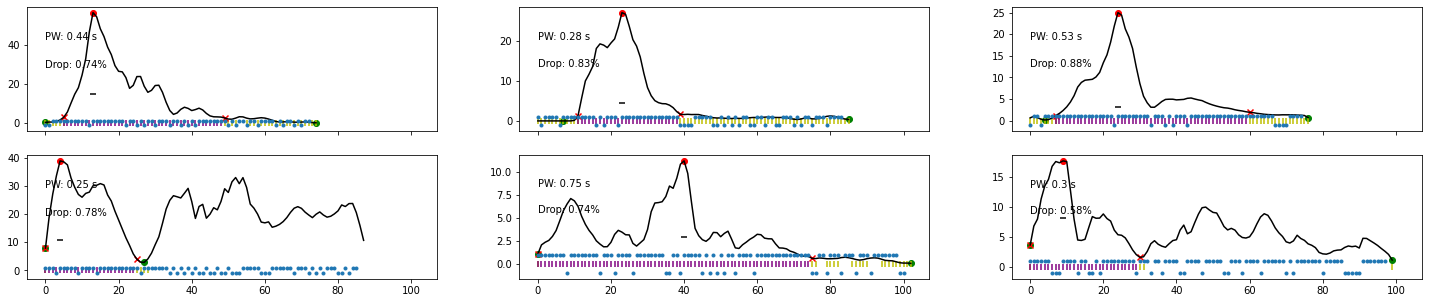

In [8]:
FPS = 100
n_plots = 3
types = ["A", "B"]
fig, axs = plt.subplots(2, n_plots, figsize=(25,5), sharex=True)
rands = np.random.randint(1,50, size=n_plots)
for i in range(n_plots):
    n = rands[i]
    for j, type in enumerate(types):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            sig = madmom.audio.signal.Signal(
                "datasets/articulation/" + "{}_violin/{}{}.wav".format(
                    type, str.lower(type), n
                ),
                dtype=float
            )
        frames = madmom.audio.signal.FramedSignal(signal=sig, frame_size=1024, fps=100)
        energy = frames.energy()
        rel_tol = 0.05
        left_shift = 0.05
        right_shift = 0.1
        max = np.max(energy)
        min = np.min(energy)
        tol = rel_tol*(max-min)
        amax = np.argmax(energy)
        lat_left = amax - left_shift
        lat_right = amax + right_shift
        rel_drop, _, lateral_energy = peak_sharpness(energy, left_shift, right_shift)
        left_min = np.min(energy[:amax])
        right_min = np.min(energy[amax:])
        left_amin = np.argmin(energy[:amax])
        right_amin = np.argmin(energy[amax:]) + amax
        axs[j,i].scatter(left_amin, left_min, c='g')
        axs[j,i].scatter(right_amin, right_min, c='g')
        
        left_idx = np.where(energy[:amax]<=left_min+tol)[0]
        axs[j,i].scatter(left_idx, np.zeros_like(left_idx), c='y', marker='|')
        right_idx = np.where(energy[amax:]<=right_min+tol)[0] + amax
        axs[j,i].scatter(right_idx, np.zeros_like(right_idx), c='y', marker='|')
        left_amaxmin = left_idx[-1]
        right_amaxmin = right_idx[0]
        left_width, right_width, peak_width = model_energy_peak(energy)

        dE_sign = (np.ediff1d(energy)>0).astype(int)*2-1
        
        axs[j,i].plot(energy, c='k')
        #axs[j,i].plot(dE_sign[:-1]*dE_sign[1:], '.')
        axs[j,i].text(x=0, y=3*max/4, s="PW: " + str(peak_width) + " s")
        axs[j,i].text(x=0, y=max/2, s="Drop: " + "{:.2f}".format(rel_drop) + "%")
        axs[j,i].scatter(amax, energy[amax], c='r')
        axs[j,i].scatter(left_amaxmin, energy[left_amaxmin], marker='x', c='red')
        axs[j,i].scatter(right_amaxmin, energy[right_amaxmin], marker='x', c='red')
        axs[j,i].scatter(np.arange(left_amaxmin, right_amaxmin), np.zeros(right_amaxmin - left_amaxmin), c='purple', marker='|')
        axs[j,i].scatter(amax, lateral_energy, marker='_', c='k')

        

In [111]:
train_idx = list(np.arange(1,4)) + list(np.arange(5, 40))
types = ["A", "B"]
print(len(train_idx))

# Peak width
pws = np.zeros((len(train_idx), len(types), 3))

# Relative drop
rds = np.zeros((len(train_idx), len(types)))

for i, n in enumerate(train_idx):
    for j, type in enumerate(types):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            sig = madmom.audio.signal.Signal(
                "datasets/articulation/" + "{}_violin/{}{}.wav".format(
                    type, str.lower(type), n
                ),
                dtype=float
            )
        frames = madmom.audio.signal.FramedSignal(signal=sig, frame_size=1024, fps=100)
        energy = frames.energy()
        left_width, right_width, peak_width = model_energy_peak(energy)
        rd,_,_ = peak_sharpness(energy, 0.05, 0.1)
        pws[i, j, 0] = left_width
        pws[i, j, 1] = right_width
        pws[i, j, 2] = peak_width
        rds[i,j] = rd

38


In [112]:
print("Peak width stats (per class)")
print("Left mean: ", pws[:,:,0].mean(0))
print("Right mean: ", pws[:,:,1].mean(0))

print()
print("Relative peak energy drop (per class)")
print("Mean: ", rds.mean(0))
print("Std: ", rds.std(0))

Peak width stats (per class)
Left mean:  [0.10868421 0.38342105]
Right mean:  [0.20605263 0.39815789]

Relative peak energy drop (per class)
Mean:  [0.77577175 0.59702927]
Std:  [0.18832424 0.18045586]
